# Hans 2024 data v2

Let's take a look at the perplexity ratio score data generated with the v2 scoring algorithm.

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import configuration as config

/mnt/arkk/llm_detector/classifier


Load the scored text fragment data from the Hans 2024 corpus.

In [2]:
# Load the data
data_df = pd.read_json(f'{config.HANS_DATA_PATH}/falcon-7b_scores_v2.json')

# Replace and remove string 'OOM' and 'NAN' values
data_df.replace('NAN', np.nan, inplace = True)
data_df.replace('OOM', np.nan, inplace = True)
data_df.dropna(inplace = True)

# Enforce dtypes
data_df = data_df.astype({
    'Source record num': int,
    'Fragment length (words)': int,
    'Fragment length (tokens)': int,
    'Dataset': str,
    'Source': str,
    'String': str,
    'Perplexity': float,
    'Cross-perplexity': float,
    'Perplexity ratio score': float,
    'Reader time (seconds)': float,
    'Writer time (seconds)': float,
    'Reader peak memory (GB)': float,
    'Writer peak memory (GB)': float
})

# get rid of some unnecessary columns
data_df.drop([
    'Source record num', 
    'Reader time (seconds)',
    'Writer time (seconds)',
    'Reader peak memory (GB)',
    'Writer peak memory (GB)'
], axis = 1, inplace = True)

# Filter out PubMed
data_df = data_df[data_df['Dataset'] != 'pubmed']

# Shuffle the deck, resetting the index
data_df = data_df.sample(frac = 1).reset_index(drop = True)
data_df.reset_index(inplace = True, drop = True)

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15895 entries, 0 to 15894
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fragment length (words)   15895 non-null  int64  
 1   Fragment length (tokens)  15895 non-null  int64  
 2   Dataset                   15895 non-null  object 
 3   Source                    15895 non-null  object 
 4   String                    15895 non-null  object 
 5   Perplexity                15895 non-null  float64
 6   Cross-perplexity          15895 non-null  float64
 7   Perplexity ratio score    15895 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 993.6+ KB


Take a quick look for sanity...

In [3]:
# Get human and synthetic fragments
human_fragments = data_df[data_df['Source'] == 'human']
synthetic_fragments = data_df[data_df['Source'] == 'synthetic']

# Get the size of each
human_fragment_count = len(human_fragments)
synthetic_fragment_count = len(synthetic_fragments)

# And the percent synthetic
percent_synthetic = round((synthetic_fragment_count / (synthetic_fragment_count + human_fragment_count)) * 100, 1)

print(f'Have {human_fragment_count} human text fragments and {synthetic_fragment_count} synthetic fragments.')
print(f'Dataset is {percent_synthetic}% synthetic fragments.')

Have 7953 human text fragments and 7942 synthetic fragments.
Dataset is 50.0% synthetic fragments.


In [4]:
data_df.head()

,Fragment length (words),Fragment length (tokens),Dataset,Source,String,Perplexity,Cross-perplexity,Perplexity ratio score
0,11,13,cc_news,synthetic,also informed Geingob that he would be visitin...,4.227,4.449219,0.949956
1,114,165,cc_news,human,notify Amtrak conductors to hold the train for...,2.812,2.947266,0.954274
2,226,305,cnn,synthetic,able to prove a connection between the women.\...,2.014,2.484375,0.810535
3,260,338,cnn,human,Mr McGrath said that the AGA is billed as a fa...,2.969,2.794922,1.062194
4,374,492,cc_news,human,a heavenly choir to fill the room. He heard no...,3.068,2.902344,1.057201


In [5]:
data_df.tail()

,Fragment length (words),Fragment length (tokens),Dataset,Source,String,Perplexity,Cross-perplexity,Perplexity ratio score
15890,61,98,cc_news,synthetic,predicting the arrival of a huge asteroid call...,2.060,2.599609,0.792637
15891,213,276,cc_news,human,partnered with Temple Theaters on “Waiting for...,2.555,2.585938,0.987915
15892,288,362,cc_news,synthetic,"Tesla Inc. CEO, who has a history of making in...",2.371,2.611328,0.908003
15893,214,290,cnn,human,"Legal battle: Dentist Anca Macavei, who tried ...",2.422,2.445312,0.990415
15894,170,230,cc_news,human,"BROOKLYN, N.Y. (CN) – Setting the stage for a ...",2.312,2.474609,0.934491


Make some plots with perplexity ratio score and related variables to what we have.

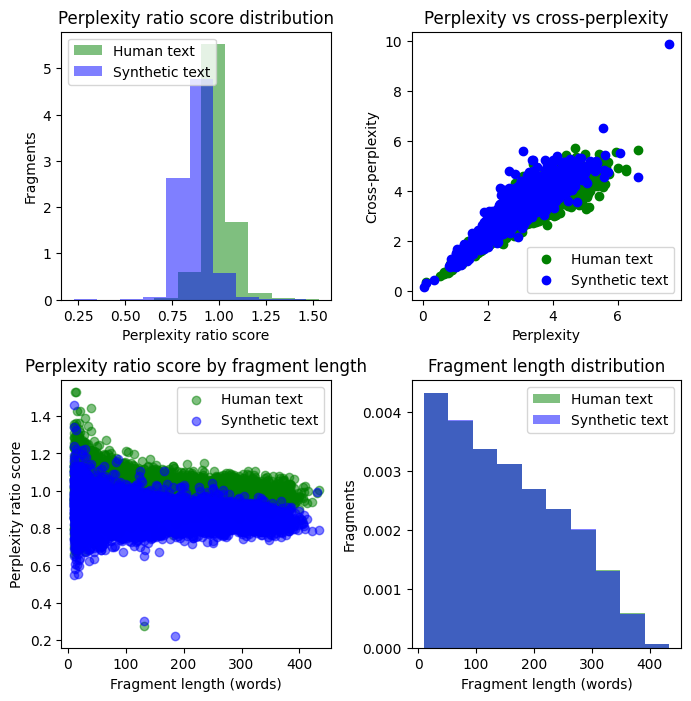

In [6]:
# Set up a 2 x 2 figure for some diagnostic plots
fig, axs = plt.subplots(
    2,
    2,
    figsize = (8, 8),
    gridspec_kw = {'wspace':0.3, 'hspace':0.3}
)

# Plot distribution of perplexity ratio scores
axs[0,0].set_title('Perplexity ratio score distribution')
axs[0,0].hist(human_fragments['Perplexity ratio score'], density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[0,0].hist(synthetic_fragments['Perplexity ratio score'], density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[0,0].legend(loc = 'upper left')
axs[0,0].set_xlabel('Perplexity ratio score')
axs[0,0].set_ylabel('Fragments')

# Scatter plot of perplexity vs cross-perplexity
axs[0,1].set_title('Perplexity vs cross-perplexity')
axs[0,1].scatter(human_fragments['Perplexity'], human_fragments['Cross-perplexity'], c = 'green', label = 'Human text')
axs[0,1].scatter(synthetic_fragments['Perplexity'], synthetic_fragments['Cross-perplexity'], c = 'blue', label = 'Synthetic text')
axs[0,1].legend(loc = 'lower right')
axs[0,1].set_xlabel('Perplexity')
axs[0,1].set_ylabel('Cross-perplexity')

# Scatter plot of perplexity ratio score as a function of the
# the text fragment length
axs[1,0].set_title('Perplexity ratio score by fragment length')
axs[1,0].scatter(human_fragments['Fragment length (words)'], human_fragments['Perplexity ratio score'], c = 'green', alpha = 0.5, label = 'Human text')
axs[1,0].scatter(synthetic_fragments['Fragment length (words)'], synthetic_fragments['Perplexity ratio score'], c = 'blue', alpha = 0.5, label = 'Synthetic text')
axs[1,0].legend(loc = 'upper right')
axs[1,0].set_xlabel('Fragment length (words)')
axs[1,0].set_ylabel('Perplexity ratio score')

# Plot length distributions for human and synthetic text fragments
axs[1,1].set_title('Fragment length distribution')
axs[1,1].hist(human_fragments['Fragment length (words)'], density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[1,1].hist(synthetic_fragments['Fragment length (words)'], density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[1,1].legend(loc = 'upper right')
axs[1,1].set_xlabel('Fragment length (words)')
axs[1,1].set_ylabel('Fragments')

plt.show()

Next, let's split the data in to training and testing subsets. This way as we do the feature engineering steps we are not leaking data.

In [7]:
training_df = data_df.sample(frac = 0.8, random_state = 42)
testing_df = data_df.drop(training_df.index)

training_df.reset_index(inplace = True, drop = True)
testing_df.reset_index(inplace = True, drop = True)

print(f'Have {len(training_df)} training examples')
print(f'Have {len(testing_df)} testing examples')
print()
testing_df.info()

Have 12716 training examples
Have 3179 testing examples

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3179 entries, 0 to 3178
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fragment length (words)   3179 non-null   int64  
 1   Fragment length (tokens)  3179 non-null   int64  
 2   Dataset                   3179 non-null   object 
 3   Source                    3179 non-null   object 
 4   String                    3179 non-null   object 
 5   Perplexity                3179 non-null   float64
 6   Cross-perplexity          3179 non-null   float64
 7   Perplexity ratio score    3179 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 198.8+ KB


And finally, save the split data for future use.

In [8]:
# Save training data
output_file = config.COMBINED_SCORED_HANS_TRAINING_DATA

with open(output_file, 'w') as file:
    file.write(training_df.to_json())

# Save testing data
output_file = config.COMBINED_SCORED_HANS_TESTING_DATA

with open(output_file, 'w') as file:
    file.write(testing_df.to_json())